In [2]:
import torch
import cv2
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet50

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
train_df = pd.read_csv('../../GTSRB/Train.csv')
train_df = train_df[train_df['Path'].str[-6:-4].astype(int)==29]
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
29,166,152,15,14,152,139,20,Train/20/00020_00000_00029.png
59,69,58,6,5,63,53,20,Train/20/00020_00001_00029.png
89,105,99,10,8,96,91,20,Train/20/00020_00002_00029.png
119,117,118,7,11,107,108,20,Train/20/00020_00003_00029.png
149,58,58,5,5,53,53,20,Train/20/00020_00004_00029.png


In [6]:
pd.unique(train_df['ClassId'])

array([20,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=int64)

In [7]:
len(train_df)

1306

In [8]:
test_df = pd.read_csv('../../GTSRB/Test.csv')
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [9]:
class MyDataset(Dataset):
    def __init__(self, path, df, transforms):
        self.path = path
        self.df = df
        self.len = len(df)
        self.transforms = transforms
    def __len__(self):
        return self.len
    def __getitem__(self, index):
        im_path = self.df['Path'].iloc[index]
        image_transforms['train']
        img = cv2.imread(self.path+im_path)
        img = Image.fromarray(img)
        img = img.convert('RGB')
        img = self.transforms(img)
        label = self.df['ClassId'].iloc[index]
        return img, label

In [10]:
path = '../../GTSRB/'
train_dataset = MyDataset(path, train_df, image_transforms['train'])
test_dataset = MyDataset(path, test_df.iloc[:300], image_transforms['test'])

In [11]:
len(train_dataset)/32

40.8125

In [12]:
# Dataloader iterators, make sure to shuffle
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [13]:
res_model = resnet18(pretrained=True)

In [14]:
#freeze weights
for param in res_model.parameters():
    param.requires_grad = False

In [15]:
in_features = res_model.fc.in_features
in_features

512

In [16]:
res_model.fc = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 43))

In [17]:
res_model.to(device);

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res_model.parameters(), lr=.01)

In [19]:
n_epochs = 10
train_loss = []
train_acc = []
for epoch in range(n_epochs):
    running_loss = 0
    running_correct = 0
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)
        # Generate predictions
        outputs = res_model(data)
        # Calculate loss
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        # Update model parameters
        optimizer.step()
        # Loss and accuracy calc
        preds = torch.argmax(outputs, axis=1)
        running_loss += loss.item()
        running_correct += torch.sum(preds == targets.data)
    epoch_loss = running_loss/len(train_loader.dataset)
    epoch_acc = running_correct.float()/ len(train_loader.dataset)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

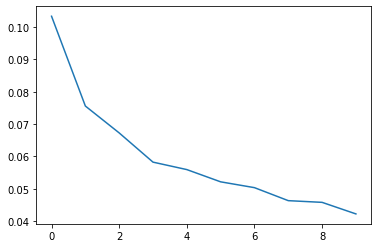

In [20]:
plt.plot(train_loss)

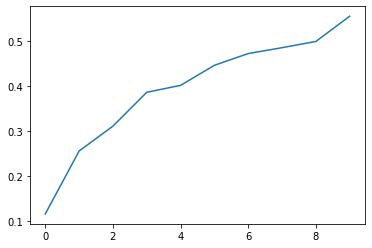

In [21]:
plt.plot(train_acc)

In [22]:
res_model.eval();

In [23]:
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    preds = res_model(data)
    preds = torch.argmax(preds, axis=1)
    correct += torch.sum(preds==target.data)
    
correct.item()/len(test_loader.dataset)

0.37333333333333335

In [24]:
res2_model = resnet50(pretrained=True)

In [25]:
#freeze weights
for param in res2_model.parameters():
    param.requires_grad = False

In [26]:
in_features = res2_model.fc.in_features
in_features

2048

In [27]:
res2_model.fc = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 43))

In [28]:
res2_model.to(device);

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res2_model.parameters(), lr=.01)

In [30]:
n_epochs = 5
train_loss = []
train_acc = []
for epoch in range(n_epochs):
    running_loss = 0
    running_correct = 0
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)
        # Generate predictions
        outputs = res2_model(data)
        # Calculate loss
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        # Update model parameters
        optimizer.step()
        # Loss and accuracy calc
        preds = torch.argmax(outputs, axis=1)
        running_loss += loss.item()
        running_correct += torch.sum(preds == targets.data)
    epoch_loss = running_loss/len(train_loader.dataset)
    epoch_acc = running_correct.float()/ len(train_loader.dataset)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

RuntimeError: CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 2.00 GiB total capacity; 381.87 MiB already allocated; 37.53 MiB free; 66.13 MiB cached)

In [ ]:
plt.plot(train_loss)

In [ ]:
plt.plot(train_acc)

In [ ]:
small_train_df = pd.read_csv('../../GTSRB/Train.csv')
small_train_df = small_train_df[small_train_df['ClassId']<10]
small_train_df = small_train_df[small_train_df['Path'].str[-6:-4].astype(int)>20]

In [ ]:
len(small_train_df)/32

In [ ]:
small_train_dataset = MyDataset(path, small_train_df, image_transforms['train'])
small_train_loader = DataLoader(small_train_dataset, batch_size=32, shuffle=True)

In [ ]:
res3_model = resnet18(pretrained=True)

In [ ]:
#freeze weights
for param in res3_model.parameters():
    param.requires_grad = False

In [ ]:
in_features = res3_model.fc.in_features
in_features

In [ ]:
res3_model.fc = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10))

In [ ]:
res3_model.to(device);

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res3_model.parameters(), lr=.005)

In [ ]:
n_epochs = 8
train_loss = []
train_acc = []
for epoch in range(n_epochs):
    running_loss = 0
    running_correct = 0
    for data, targets in small_train_loader:
        data = data.to(device)
        targets = targets.to(device)
        # Generate predictions
        outputs = res3_model(data)
        # Calculate loss
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        # Update model parameters
        optimizer.step()
        # Loss and accuracy calc
        preds = torch.argmax(outputs, axis=1)
        running_loss += loss.item()
        running_correct += torch.sum(preds == targets.data)
    epoch_loss = running_loss/len(small_train_loader.dataset)
    epoch_acc = running_correct.float()/ len(small_train_loader.dataset)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

In [ ]:
plt.plot(train_loss)

In [ ]:
plt.plot(train_acc)
train_acc[-1]

In [ ]:
res3_model.eval();

In [ ]:
small_test_df = pd.read_csv('../../GTSRB/Test.csv')
small_test_df = small_test_df[small_test_df['ClassId']<10]
small_test_df = small_test_df.iloc[:int(len(small_test_df)*.2)]
small_test_df.head()

In [ ]:
len(small_test_df)/32

In [ ]:
small_test_dataset = MyDataset(path, small_test_df.iloc[:300], image_transforms['test'])
small_test_loader = DataLoader(small_test_dataset, batch_size=32, shuffle=True)

In [ ]:
correct = 0
for data, target in small_test_loader:
    data = data.to(device)
    target = target.to(device)
    preds = res3_model(data)
    preds = torch.argmax(preds, axis=1)
    correct += torch.sum(preds==target.data)
    
correct.item()/len(small_test_loader.dataset)